In [ ]:
# Ispirato dal video https://www.youtube.com/watch?v=6clmthGECvc&t=0s

# Metodo 1

## Importazione librerie

In [4]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

## Download dati

In [2]:
# Inizializza l'exchange
exchange = ccxt.binance()

# Definisci il simbolo e il timeframe desiderato
symbol = 'BTC/USDT'
timeframe = '1d'  # Timeframe giornaliero

# Calcola la data di inizio (ad esempio, 365 giorni fa)
since = exchange.parse8601((datetime.now() - timedelta(days=365)).strftime('%Y-%m-%dT%H:%M:%S'))

# Scarica i dati storici
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Crea un DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

df.head()

open      high       low     close       volume
timestamp                                                      
2023-11-26  37780.67  37814.63  37150.00  37447.43  21264.53723
2023-11-27  37447.42  37569.23  36707.00  37242.70  30001.07376
2023-11-28  37242.70  38377.00  36868.41  37818.87  37544.46667
2023-11-29  37818.88  38450.00  37570.00  37854.64  32994.19107
2023-11-30  37854.65  38145.85  37500.00  37723.96  24740.29147

## Analisi ciclica

Frequenze dominanti (cicli/giorno): [0.00273973 0.00821918 0.00547945]
Periodi dominanti (giorni): [365.         121.66666667 182.5       ]


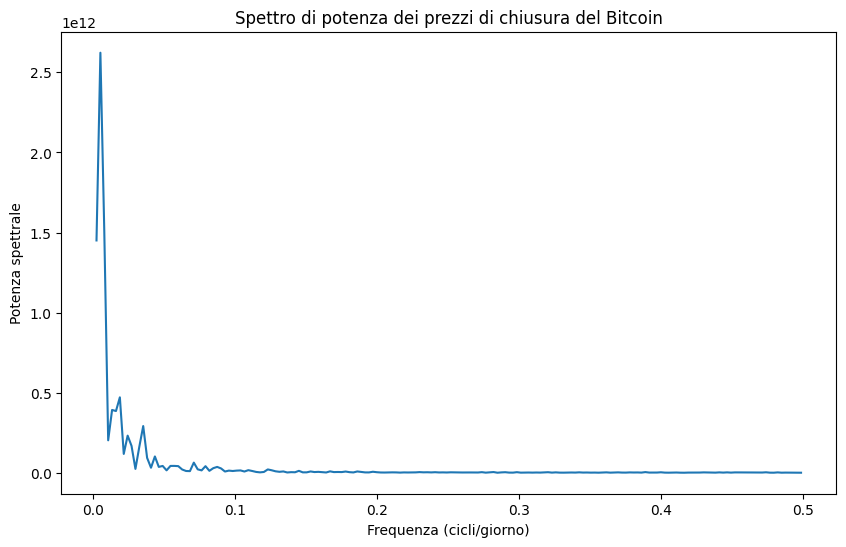

In [5]:
# Estrai i prezzi di chiusura
close_prices = df['close'].values

# Calcola la media e sottraila dai prezzi per rimuovere la componente DC
close_prices_detrended = close_prices - np.mean(close_prices)

# Applica la Trasformata di Fourier
fft_result = np.fft.fft(close_prices_detrended)
fft_freq = np.fft.fftfreq(len(fft_result))

# Calcola la potenza spettrale
power_spectrum = np.abs(fft_result)**2

# Filtra le frequenze positive
positive_freqs = fft_freq > 0
freqs = fft_freq[positive_freqs]
power = power_spectrum[positive_freqs]

# Identifica le frequenze dominanti
dominant_freqs = freqs[np.argsort(power)[-3:]]  # Le 3 frequenze con potenza maggiore
dominant_periods = 1 / dominant_freqs

print("Frequenze dominanti (cicli/giorno):", dominant_freqs)
print("Periodi dominanti (giorni):", dominant_periods)

# Visualizza lo spettro di potenza
plt.figure(figsize=(10, 6))
plt.plot(freqs, power)
plt.xlabel('Frequenza (cicli/giorno)')
plt.ylabel('Potenza spettrale')
plt.title('Spettro di potenza dei prezzi di chiusura del Bitcoin')
plt.show()

## Generazione dei segnali di trading

In [6]:
# Seleziona la frequenza dominante principale
dominant_freq = dominant_freqs[np.argmax(power)]

# Calcola il periodo dominante
dominant_period = int(1 / dominant_freq)

# Crea un indicatore sinusoidale basato sul periodo dominante
t = np.arange(len(close_prices))
sinusoid = np.sin(2 * np.pi * dominant_freq * t)

# Normalizza l'indicatore
sinusoid_normalized = (sinusoid - np.min(sinusoid)) / (np.max(sinusoid) - np.min(sinusoid))

# Aggiungi l'indicatore al DataFrame
df['sinusoid_indicator'] = sinusoid_normalized

# Genera segnali di acquisto e vendita
df['signal'] = 0
df.loc[df['sinusoid_indicator'] < 0.2, 'signal'] = 1  # Segnale di acquisto
df.loc[df['sinusoid_indicator'] > 0.8, 'signal'] = -1  # Segnale di vendita

print(df[['close', 'sinusoid_indicator', 'signal']].tail())

               close  sinusoid_indicator  signal
timestamp                                       
2024-11-20  94286.56            0.372322       0
2024-11-21  98317.12            0.397447       0
2024-11-22  98892.00            0.422845       0
2024-11-23  97672.40            0.448449       0
2024-11-24  95963.13            0.474190       0


## Implementazione del sistema di trading

In [ ]:
# def execute_trade(signal, symbol, amount):
#     if signal == 1:
#         # Esegui ordine di acquisto
#         order = exchange.create_market_buy_order(symbol, amount)
#         print(f"Acquistato {amount} di {symbol}")
#     elif signal == -1:
#         pass

# Metodo 2

## Importazione librerie

In [ ]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

## Download dati

In [8]:
# Inizializza l'exchange Binance
exchange = ccxt.binance()

# Definisci il simbolo e il timeframe
symbol = 'BTC/USDT'
timeframe = '1d'  # Timeframe giornaliero

# Definisci il numero di candele da scaricare
limit = 1000

# Scarica i dati OHLCV
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)

# Crea un DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# Converti il timestamp in formato datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Imposta il timestamp come indice
df.set_index('timestamp', inplace=True)

## Analisi ciclica

In [9]:
# Calcola la Trasformata di Fourier
fft = np.fft.fft(df['close'])
frequencies = np.fft.fftfreq(len(fft))

# Calcola la potenza spettrale
power = np.abs(fft)**2

# Filtra le frequenze positive
positive_frequencies = frequencies[frequencies > 0]
positive_power = power[frequencies > 0]

# Identifica la frequenza dominante
dominant_frequency = positive_frequencies[np.argmax(positive_power)]
dominant_period = 1 / dominant_frequency

print(f'Periodo dominante: {dominant_period} giorni')

Periodo dominante: 1000.0 giorni


## Identificazione dei minimi e massimi locali

In [10]:
# Definisci il filtro passa-basso
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Applica il filtro
cutoff = 1 / dominant_period  # Frequenza di taglio
fs = 1  # Frequenza di campionamento (1 giorno)
order = 2

b, a = butter_lowpass(cutoff, fs, order)
df['filtered'] = filtfilt(b, a, df['close'])

# Identifica minimi e massimi locali
df['min_local'] = (df['filtered'].shift(1) > df['filtered']) & (df['filtered'].shift(-1) > df['filtered'])
df['max_local'] = (df['filtered'].shift(1) < df['filtered']) & (df['filtered'].shift(-1) < df['filtered'])

## Generazione dei segnali di trading

In [11]:
df['signal'] = 0
df.loc[df['min_local'], 'signal'] = 1  # Segnale di acquisto
df.loc[df['max_local'], 'signal'] = -1  # Segnale di vendita

## Visualizzazione dei risultati

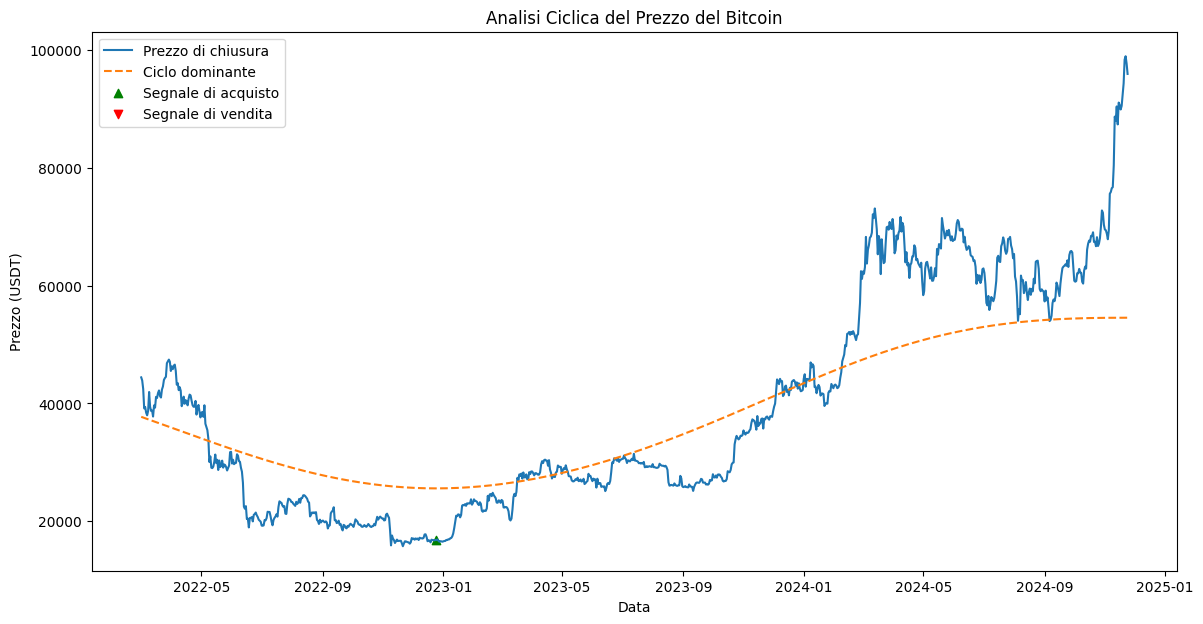

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Prezzo di chiusura')
plt.plot(df.index, df['filtered'], label='Ciclo dominante', linestyle='--')
plt.scatter(df.index[df['signal'] == 1], df['close'][df['signal'] == 1], marker='^', color='g', label='Segnale di acquisto')
plt.scatter(df.index[df['signal'] == -1], df['close'][df['signal'] == -1], marker='v', color='r', label='Segnale di vendita')
plt.legend()
plt.title('Analisi Ciclica del Prezzo del Bitcoin')
plt.xlabel('Data')
plt.ylabel('Prezzo (USDT)')
plt.show()

# Metodo 3

In [1]:
import time
import ccxt
import pandas as pd

def download_and_plot(cryptos, timeframe, start_date, end_date, plot):
    
    exchange = ccxt.binance()  # Usa Binance come exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{cryptos[0]} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [2]:
# Periodo personale
data_inizio = '2014-01-01'
data_fine = '2024-11-01'

chosen_cryptos = ['BTC']
timeframe_download = '1d'

data_frames = download_and_plot(chosen_cryptos, timeframe_download, data_inizio, data_fine, plot=False)

# Prepara il DataFrame `crypto_prices` con timestamp e prezzi di chiusura
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[chosen_cryptos[0]].index
for crypto in chosen_cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values

Scarico i dati per BTC/USDT dal 2014-01-01 al 2024-11-01...


In [3]:
data = data_frames['BTC']
data

open      high       low     close        volume
timestamp                                                       
2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377
2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264
2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763
2017-08-20   4120.98   4211.08   4032.62   4086.29    467.083022
2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060
...              ...       ...       ...       ...           ...
2024-10-28  68021.69  70270.00  67618.00  69962.21  29046.754590
2024-10-29  69962.21  73620.12  69760.00  72736.42  50128.605940
2024-10-30  72736.41  72961.00  71436.00  72344.74  26885.990560
2024-10-31  72344.75  72700.00  69685.76  70292.01  29352.102970
2024-11-01  70292.01  71632.95  68820.14  69496.01  38301.867550

[2634 rows x 5 columns]

In [4]:
# Aggiunge un filtro passa-basso ai dati per ridurre il rumore
from scipy.signal import butter, filtfilt

def smooth_data(data, cutoff=0.05, order=2):
    b, a = butter(order, cutoff, btype='low', analog=False)
    data['smoothed'] = filtfilt(b, a, data['close'])
    return data

# Applica il filtro
data = smooth_data(data)
data

open      high       low     close        volume      smoothed
timestamp                                                                     
2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377   4321.606571
2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264   4323.447108
2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763   4325.916917
2017-08-20   4120.98   4211.08   4032.62   4086.29    467.083022   4329.270242
2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060   4333.634644
...              ...       ...       ...       ...           ...           ...
2024-10-28  68021.69  70270.00  67618.00  69962.21  29046.754590  68779.585487
2024-10-29  69962.21  73620.12  69760.00  72736.42  50128.605940  68925.825123
2024-10-30  72736.41  72961.00  71436.00  72344.74  26885.990560  69050.906035
2024-10-31  72344.75  72700.00  69685.76  70292.01  29352.102970  69155.270868
2024-11-01  70292.01  71632.95  68820.14  69496.01  38301.867550  69240.934854

[2634 rows x 6 columns]

In [5]:
import numpy as np

# Trova i minimi e massimi locali
def identify_cycles(data, window=5):
    data['min_local'] = data['close'] == data['close'].rolling(window, center=True).min()
    data['max_local'] = data['close'] == data['close'].rolling(window, center=True).max()
    return data

# Identifica i cicli
data = identify_cycles(data, window=10)
data[['close', 'min_local', 'max_local']]

close  min_local  max_local
timestamp                                 
2017-08-17   4285.08      False      False
2017-08-18   4108.37      False      False
2017-08-19   4139.98      False      False
2017-08-20   4086.29      False      False
2017-08-21   4016.00      False      False
...              ...        ...        ...
2024-10-28  69962.21      False      False
2024-10-29  72736.42      False      False
2024-10-30  72344.74      False      False
2024-10-31  70292.01      False      False
2024-11-01  69496.01      False      False

[2634 rows x 3 columns]

In [6]:
def analyze_cycles(data, cycle_min, cycle_max):
    cycles = []
    current_cycle = {'start': None, 'end': None, 'type': None}
    
    for i in range(len(data)):
        if data['min_local'].iloc[i]:
            if current_cycle['start'] is None:
                current_cycle['start'] = data.index[i]
            else:
                current_cycle['end'] = data.index[i]
                duration = (current_cycle['end'] - current_cycle['start']).days
                
                # Verifica il vincolo ciclico
                if duration < cycle_min:
                    current_cycle['type'] = 'invalid (too short)'
                elif duration > cycle_max:
                    current_cycle['type'] = 'invalid (too long)'
                else:
                    current_cycle['type'] = 'valid'
                
                cycles.append(current_cycle)
                current_cycle = {'start': data.index[i], 'end': None, 'type': None}
    return cycles

# Analizza i cicli aggiornati
cycles = analyze_cycles(data, cycle_min=20, cycle_max=50)
cycles

[{'start': Timestamp('2017-09-04 00:00:00'),
  'end': Timestamp('2017-09-14 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-09-14 00:00:00'),
  'end': Timestamp('2017-09-22 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-09-22 00:00:00'),
  'end': Timestamp('2017-10-18 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-10-18 00:00:00'),
  'end': Timestamp('2017-10-24 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-10-24 00:00:00'),
  'end': Timestamp('2017-11-12 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-11-12 00:00:00'),
  'end': Timestamp('2017-12-23 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-12-23 00:00:00'),
  'end': Timestamp('2017-12-30 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-12-30 00:00:00'),
  'end': Timestamp('2018-01-11 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2018-01-11 00:00:00'),
  'end'

In [7]:
def generate_signals(data, cycles):
    data['signal'] = 0
    for cycle in cycles:
        if cycle['type'] == 'valid':
            data.loc[cycle['start'], 'signal'] = 1  # Compra
            if cycle['end'] is not None:
                data.loc[cycle['end'], 'signal'] = -1  # Vendi
    return data

# Genera i segnali
data = generate_signals(data, cycles)
data[['close', 'signal']]

close  signal
timestamp                   
2017-08-17   4285.08       0
2017-08-18   4108.37       0
2017-08-19   4139.98       0
2017-08-20   4086.29       0
2017-08-21   4016.00       0
...              ...     ...
2024-10-28  69962.21       0
2024-10-29  72736.42       0
2024-10-30  72344.74       0
2024-10-31  70292.01       0
2024-11-01  69496.01       0

[2634 rows x 2 columns]

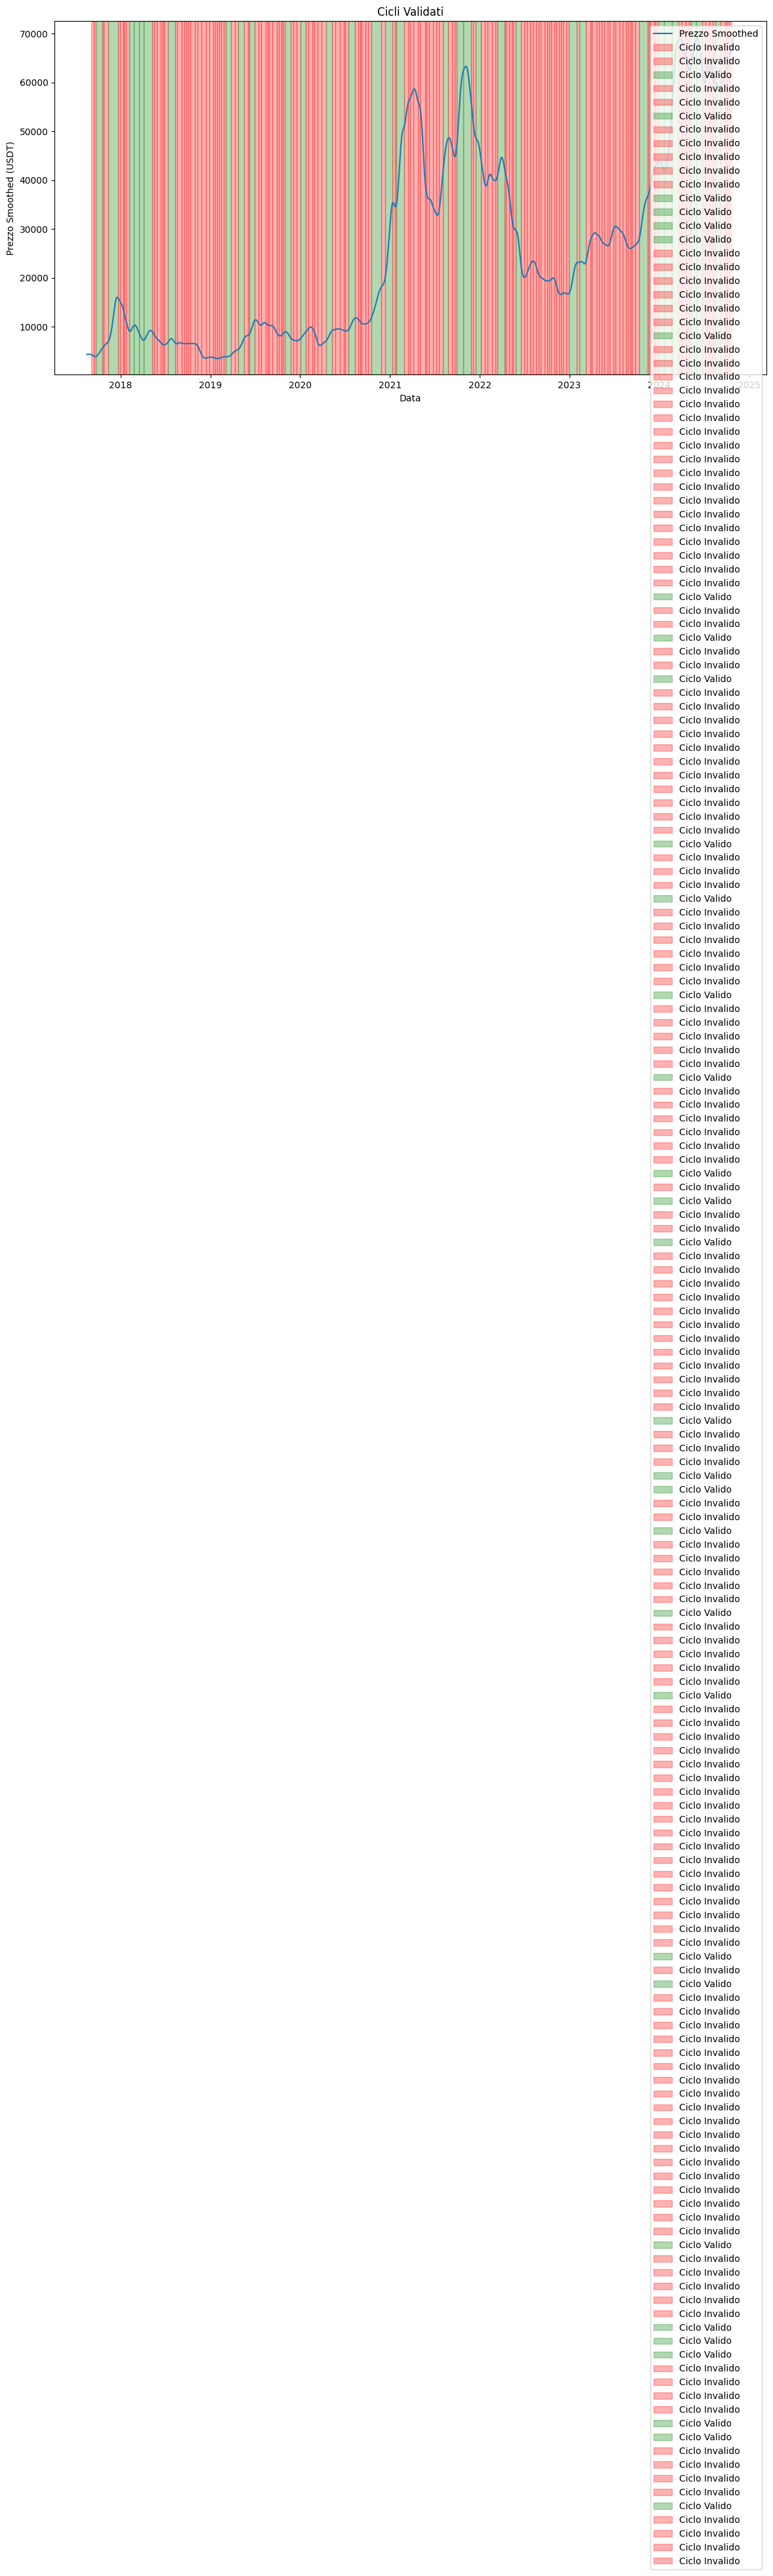

In [9]:
import matplotlib.pyplot as plt

def plot_cycles(data, cycles):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['smoothed'], label='Prezzo Smoothed')
    for cycle in cycles:
        if cycle['type'] == 'valid':
            plt.axvspan(cycle['start'], cycle['end'], color='green', alpha=0.3, label='Ciclo Valido')
        else:
            plt.axvspan(cycle['start'], cycle['end'], color='red', alpha=0.3, label='Ciclo Invalido')
    plt.legend()
    plt.title('Cicli Validati')
    plt.xlabel('Data')
    plt.ylabel('Prezzo Smoothed (USDT)')
    plt.show()

# Visualizza i cicli
plot_cycles(data, cycles)

In [10]:
# Contiamo il numero di cicli validi e invalidi
valid_cycles = [cycle for cycle in cycles if cycle['type'] == 'valid']
invalid_cycles = [cycle for cycle in cycles if cycle['type'] != 'valid']

print(f"Numero di cicli validi: {len(valid_cycles)}")
print(f"Numero di cicli invalidi: {len(invalid_cycles)}")

Numero di cicli validi: 32
Numero di cicli invalidi: 152


In [11]:
# Calcola la durata media dei cicli
cycle_durations = [(cycle['end'] - cycle['start']).days for cycle in cycles if cycle['end'] is not None]
average_cycle_duration = np.mean(cycle_durations)

# Aggiorna i parametri
cycle_min = max(10, int(average_cycle_duration * 0.5))  # Riduci il minimo
cycle_max = int(average_cycle_duration * 1.5)          # Aumenta il massimo

print(f"Nuovi parametri - Ciclo Min: {cycle_min}, Ciclo Max: {cycle_max}")

Nuovi parametri - Ciclo Min: 10, Ciclo Max: 21


In [13]:
def refine_cycles(data, cycles, tolerance=5):
    refined_cycles = []
    for cycle in cycles:
        if cycle['type'] == 'invalid (too short)' and (cycle['end'] - cycle['start']).days + tolerance >= cycle_min:
            cycle['type'] = 'valid'
        elif cycle['type'] == 'invalid (too long)' and (cycle['end'] - cycle['start']).days - tolerance <= cycle_max:
            cycle['type'] = 'valid'
        refined_cycles.append(cycle)
    return refined_cycles

# Raffina i cicli
cycles = refine_cycles(data, cycles)
cycles

[{'start': Timestamp('2017-09-04 00:00:00'),
  'end': Timestamp('2017-09-14 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-09-14 00:00:00'),
  'end': Timestamp('2017-09-22 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-09-22 00:00:00'),
  'end': Timestamp('2017-10-18 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-10-18 00:00:00'),
  'end': Timestamp('2017-10-24 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-10-24 00:00:00'),
  'end': Timestamp('2017-11-12 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-11-12 00:00:00'),
  'end': Timestamp('2017-12-23 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-12-23 00:00:00'),
  'end': Timestamp('2017-12-30 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-12-30 00:00:00'),
  'end': Timestamp('2018-01-11 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-01-11 00:00:00'),
  'end': Timestamp('2018-01-16 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-0

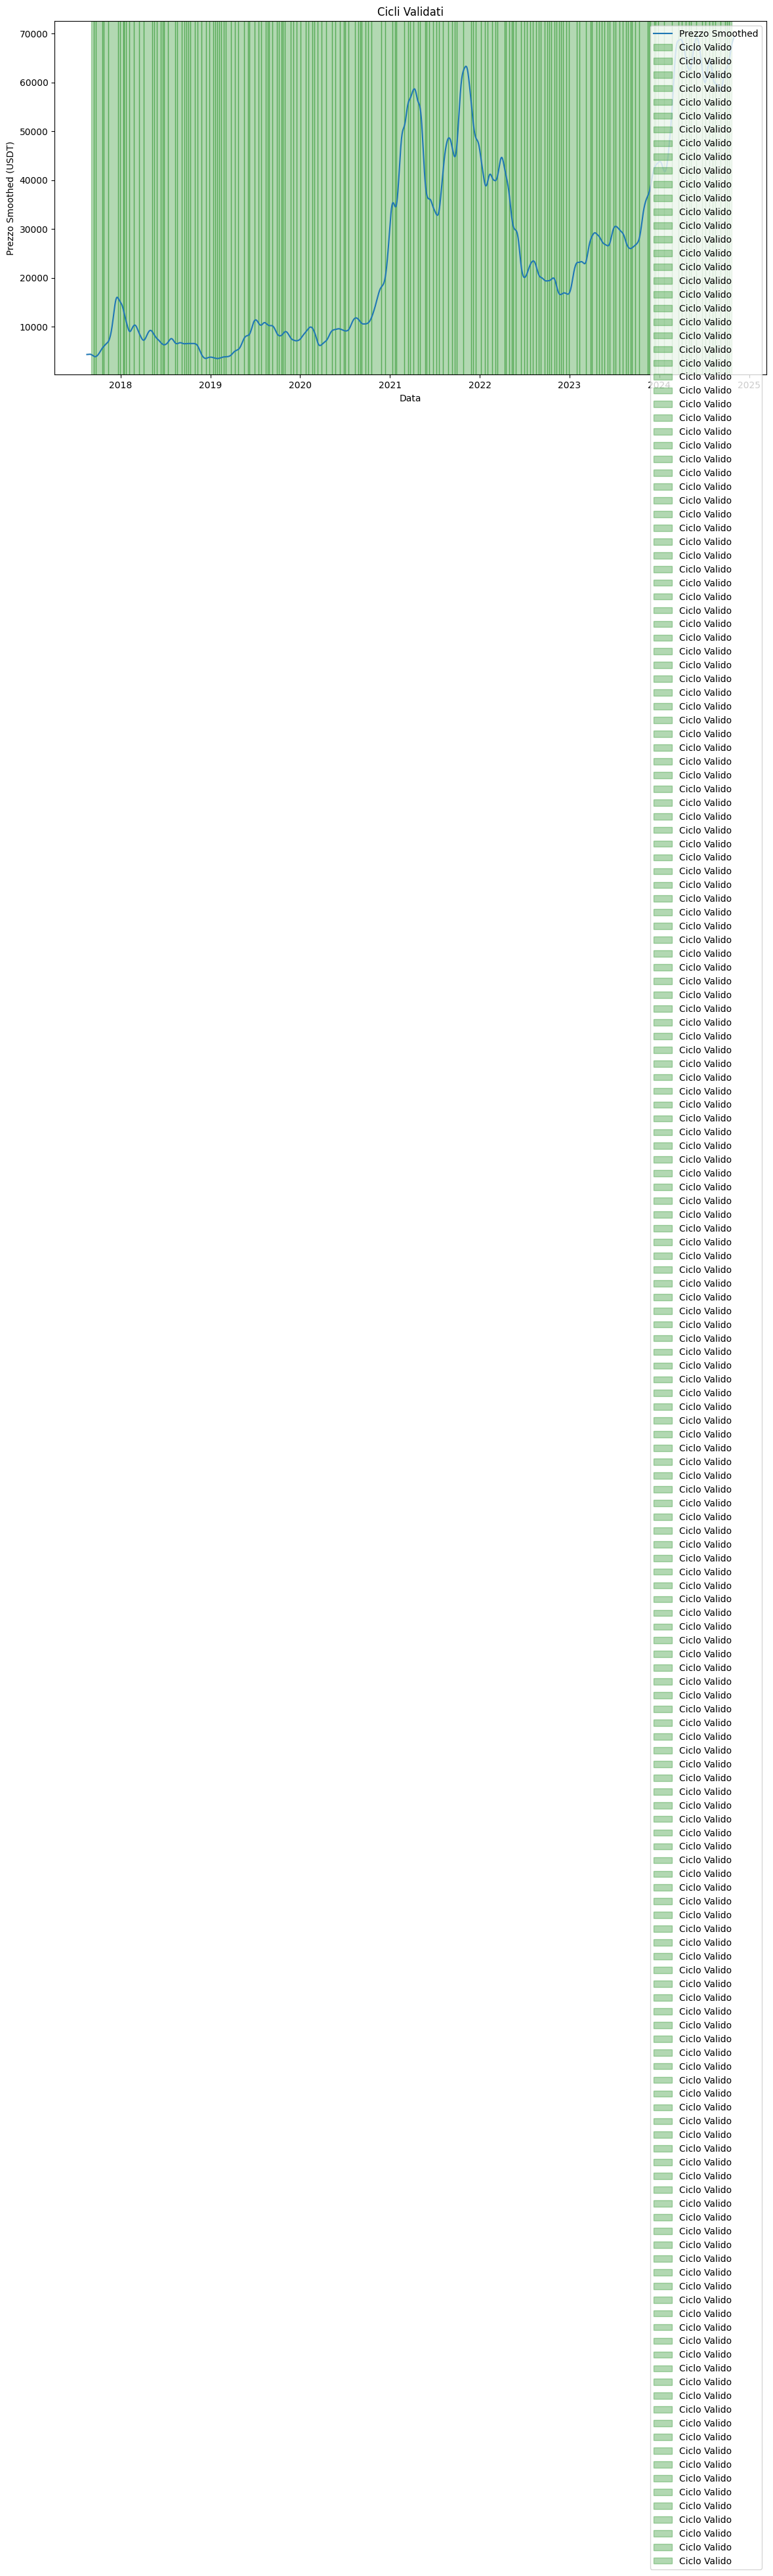

In [14]:
plot_cycles(data, cycles)

In [15]:
def filter_cycles_by_price(data, cycles, min_price_change=5):
    refined_cycles = []
    for cycle in cycles:
        if cycle['type'] == 'valid' and cycle['end'] is not None:
            price_start = data.loc[cycle['start'], 'close']
            price_end = data.loc[cycle['end'], 'close']
            price_change = abs(price_end - price_start) / price_start * 100  # Variazione percentuale
            if price_change >= min_price_change:
                refined_cycles.append(cycle)
    return refined_cycles

# Filtra i cicli validi
cycles = filter_cycles_by_price(data, cycles, min_price_change=10)  # Almeno il 10% di variazione
cycles

[{'start': Timestamp('2017-09-04 00:00:00'),
  'end': Timestamp('2017-09-14 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-09-14 00:00:00'),
  'end': Timestamp('2017-09-22 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-09-22 00:00:00'),
  'end': Timestamp('2017-10-18 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-11-12 00:00:00'),
  'end': Timestamp('2017-12-23 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-01-11 00:00:00'),
  'end': Timestamp('2018-01-16 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-01-22 00:00:00'),
  'end': Timestamp('2018-02-05 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-02-05 00:00:00'),
  'end': Timestamp('2018-02-25 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-02-25 00:00:00'),
  'end': Timestamp('2018-03-17 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-03-17 00:00:00'),
  'end': Timestamp('2018-04-06 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-0

In [16]:
def penalize_frequent_cycles(cycles, min_gap=10):
    refined_cycles = []
    last_end = None
    for cycle in cycles:
        if last_end is None or (cycle['start'] - last_end).days >= min_gap:
            refined_cycles.append(cycle)
        last_end = cycle['end']
    return refined_cycles

# Penalizza i cicli sovrapposti
cycles = penalize_frequent_cycles(cycles, min_gap=15)  # Almeno 15 giorni di distanza tra i cicli
cycles

[{'start': Timestamp('2017-09-04 00:00:00'),
  'end': Timestamp('2017-09-14 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-11-12 00:00:00'),
  'end': Timestamp('2017-12-23 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-01-11 00:00:00'),
  'end': Timestamp('2018-01-16 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-11-09 00:00:00'),
  'end': Timestamp('2018-11-26 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2019-03-25 00:00:00'),
  'end': Timestamp('2019-04-11 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2019-06-09 00:00:00'),
  'end': Timestamp('2019-07-01 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2019-09-10 00:00:00'),
  'end': Timestamp('2019-09-29 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2019-10-24 00:00:00'),
  'end': Timestamp('2019-10-31 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2020-01-02 00:00:00'),
  'end': Timestamp('2020-01-25 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2020-0

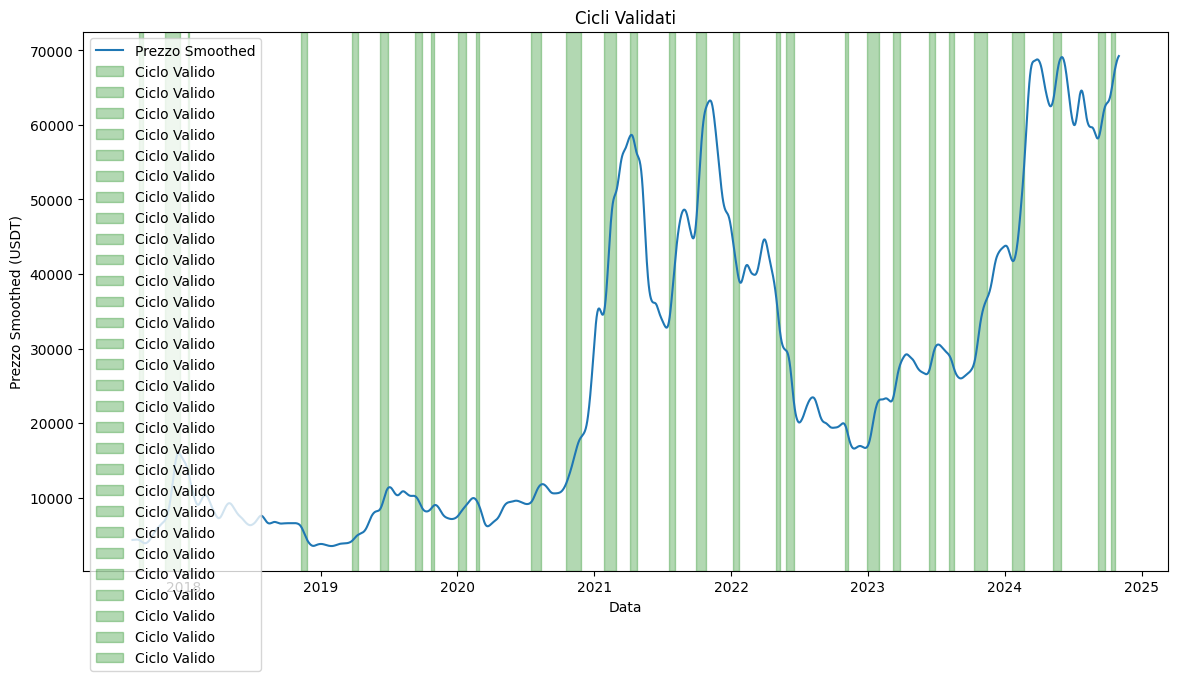

In [17]:
plot_cycles(data, cycles)

In [18]:
def backtest(data):
    balance = 1000  # Capitale iniziale in USDT
    position = 0  # Bitcoin posseduti
    for i in range(len(data)):
        if data['signal'].iloc[i] == 1:  # Compra
            if balance > 0:
                position = balance / data['close'].iloc[i]
                balance = 0
        elif data['signal'].iloc[i] == -1:  # Vendi
            if position > 0:
                balance = position * data['close'].iloc[i]
                position = 0
    # Valore finale (se rimangono Bitcoin non venduti)
    final_balance = balance + (position * data['close'].iloc[-1])
    return final_balance

# Esegui il backtest
final_balance = backtest(data)
print(f"Bilancio finale: {final_balance:.2f} USDT")

Bilancio finale: 125230.99 USDT


In [19]:
def split_data(data, train_days=60, test_days=30):
    total_days = len(data)
    blocks = []
    for start in range(0, total_days - train_days - test_days, test_days):
        train_start = start
        train_end = start + train_days
        test_start = train_end
        test_end = train_end + test_days
        
        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[test_start:test_end]
        blocks.append((train_data, test_data))
    return blocks

# Suddividi i dati in blocchi
blocks = split_data(data, train_days=60, test_days=30)
blocks

[(               open     high      low    close       volume     smoothed  \
  timestamp                                                                  
  2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377  4321.606571   
  2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264  4323.447108   
  2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763  4325.916917   
  2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022  4329.270242   
  2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060  4333.634644   
  2017-08-22  4016.00  4104.82  3400.00  4040.00   966.684858  4338.984753   
  2017-08-23  4040.00  4265.80  4013.89  4114.01  1001.136565  4345.122911   
  2017-08-24  4147.00  4371.68  4085.01  4316.01   787.418753  4351.687735   
  2017-08-25  4316.01  4453.91  4247.48  4280.68   573.612740  4358.198124   
  2017-08-26  4280.71  4367.00  4212.41  4337.44   228.108068  4364.104910   
  2017-08-27  4332.51  4400.00  4285.54  4310.01   350.692585  4

# Metodo 4

In [11]:
# https://chatgpt.com/share/6769d237-f008-8009-a7db-972e42694c92

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Se vuoi la Lomb-Scargle
from astropy.timeseries import LombScargle

In [40]:
# Esempio: carico un CSV con colonne [Date, Open, High, Low, Close, Volume]
df = pd.read_csv('bitcoin_data_28-4-2013_4-3-2024_granularità_1_giorno.csv', parse_dates=['Timestamp'])
df.rename(columns={'Timestamp': 'Date', 'Price (€)': 'Close'}, inplace=True)
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

## Definizione delle etichette (min/max locali)

In [41]:
def define_local_extrema_label(prices):
    """
    prices: array-like dei prezzi (Close)
    Ritorna un array di etichette con -1 (minimo), 1 (massimo) e 0 (nessuno)
    """
    labels = np.zeros(len(prices))

    for i in range(1, len(prices)-1):
        if prices[i] < prices[i-1] and prices[i] < prices[i+1]:
            labels[i] = -1  # Minimo locale
        elif prices[i] > prices[i-1] and prices[i] > prices[i+1]:
            labels[i] = 1   # Massimo locale
        else:
            labels[i] = 0   # Nessuno

    return labels

df['Label'] = define_local_extrema_label(df['Close'].values)

## Calcolo feature cicliche

In [42]:
def compute_lomb_scargle_features(times, prices, max_freq=0.5, num_freqs=50):
    """
    times: array di date in formato numerico (ad es. giorni dal primo giorno)
    prices: array dei prezzi
    max_freq: frequenza massima da considerare
    num_freqs: quante frequenze testare
    Ritorna un DataFrame con alcune feature cicliche (ampiezze delle freq dominanti).
    """
    # Lomb-Scargle
    frequencies = np.linspace(0.01, max_freq, num_freqs)
    ls = LombScargle(times, prices)
    power = ls.power(frequencies)

    # Prendiamo le prime k frequenze con la power più alta
    k = 10  # ad es., prendiamo le 3 freq più dominanti
    idx_top = np.argsort(power)[-k:]  # indici delle frequenze + grandi
    top_freqs = frequencies[idx_top]

    # Creiamo feature sinusoidi
    features_dict = {}
    for idx, freq in enumerate(top_freqs):
        # Salvo amplitude e phase come feature
        features_dict[f'freq_{idx}_val'] = ls.model(times, freq)

    return pd.DataFrame(features_dict)

# Convertiamo le date in numeri (es. numero di giorni dal primo giorno)
df['Days'] = (df['Date'] - df['Date'].iloc[0]).dt.days
features_cicliche = compute_lomb_scargle_features(
    df['Days'].values,
    df['Close'].values,
    max_freq=0.3,  # frequenza massima (al giorno)
    num_freqs=1000  # più frequenze, più fine la griglia
)

# Uniamo le features cicliche al dataframe
df = pd.concat([df, features_cicliche], axis=1)

## Split Train/Validation/Test

In [43]:
# Teniamo solo le righe valide (tranciamo i boundary iniziale e finale)
df = df.iloc[1:-1].copy()  # perché la label lì è definita

X = df.drop(['Date','Label','Days'], axis=1)  # Caratteristiche
y = df['Label']

# Primo split train+val / test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Poi, all'interno di train_val, facciamo un ulteriore split per la validazione
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=False
)

## Addestramento modello base

In [44]:
model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=50,
    random_state=42
)

model.fit(X_train, y_train)

# Valutiamo su validation set
y_val_pred = model.predict(X_val)
report = classification_report(y_val, y_val_pred)
print("\nValidation Classification Report:\n", report)

print("Confusion Matrix Validation:")
display(confusion_matrix(y_val, y_val_pred))


Validation Classification Report:
               precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       225
         0.0       0.43      0.94      0.59       342
         1.0       0.27      0.04      0.08       225

    accuracy                           0.42       792
   macro avg       0.23      0.33      0.22       792
weighted avg       0.26      0.42      0.27       792

Confusion Matrix Validation:


array([[  0, 218,   7],
       [  2, 320,  20],
       [  1, 214,  10]])

## (Facoltativo) Tuning iperparametri

In [48]:
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [3, 5, 50, None],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=3,  # in caso di time series, meglio una CV "time series split"
    scoring='f1_macro',  # essendo un problema multi-classe
    n_jobs=-1,
    verbose=10
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Params: {'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 50}


In [49]:
# Ricontrollo su validation
y_val_pred = best_model.predict(X_val)
report = classification_report(y_val, y_val_pred)
print("\nValidation Classification Report:\n", report)


Validation Classification Report:
               precision    recall  f1-score   support

        -1.0       0.43      0.01      0.03       225
         0.0       0.42      0.86      0.57       342
         1.0       0.26      0.10      0.15       225

    accuracy                           0.40       792
   macro avg       0.37      0.33      0.25       792
weighted avg       0.38      0.40      0.29       792



## Test finale

In [50]:
y_test_pred = best_model.predict(X_test)
test_report = classification_report(y_test, y_test_pred)
print("\nTest Classification Report:\n", test_report)

print("Confusion Matrix Test:")
print(confusion_matrix(y_test, y_test_pred))


Test Classification Report:
               precision    recall  f1-score   support

        -1.0       0.50      0.00      0.01       213
         0.0       0.47      0.88      0.62       366
         1.0       0.32      0.16      0.21       213

    accuracy                           0.45       792
   macro avg       0.43      0.35      0.28       792
weighted avg       0.44      0.45      0.34       792

Confusion Matrix Test:
[[  1 182  30]
 [  0 323  43]
 [  1 178  34]]


# Metodo 5 (miglioramento metodo 3 tramite o1)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [30]:
import time
import ccxt
import pandas as pd

def download_and_plot(cryptos, timeframe, start_date, end_date, plot):
    
    exchange = ccxt.binance()  # Usa Binance come exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        df['Date'] = df.index
        df.reset_index(drop=True, inplace=True)
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{cryptos[0]} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [31]:
# Periodo personale
data_inizio = '2024-09-01'
data_fine = '2024-12-23'

chosen_cryptos = ['BTC']
timeframe_download = '1h'

data_frames = download_and_plot(chosen_cryptos, timeframe_download, data_inizio, data_fine, plot=False)

# Prepara il DataFrame `crypto_prices` con timestamp e prezzi di chiusura
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[chosen_cryptos[0]].index
for crypto in chosen_cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values

Scarico i dati per BTC/USDT dal 2024-09-01 al 2024-12-23...


In [32]:
data = data_frames['BTC']
data

open      high       low     close      volume                Date
0     58974.00  59076.59  58900.00  58930.00   289.12701 2024-09-01 00:00:00
1     58929.99  58957.00  58819.78  58828.01   330.21542 2024-09-01 01:00:00
2     58828.00  58851.65  58276.01  58540.25  1256.77642 2024-09-01 02:00:00
3     58540.25  58672.01  58399.01  58524.21   437.88318 2024-09-01 03:00:00
4     58524.21  58599.98  58355.00  58442.00   359.59086 2024-09-01 04:00:00
...        ...       ...       ...       ...         ...                 ...
2708  94836.55  95624.00  94424.00  95592.49  1089.42566 2024-12-22 20:00:00
2709  95592.49  95740.00  95069.03  95203.11   734.29415 2024-12-22 21:00:00
2710  95203.10  95640.00  94250.35  95547.41  1382.41430 2024-12-22 22:00:00
2711  95547.42  95824.00  95024.00  95186.27   777.54805 2024-12-22 23:00:00
2712  95186.28  95410.77  94333.33  94390.84  1150.62099 2024-12-23 00:00:00

[2713 rows x 6 columns]

In [33]:
###############################################################################
# 1) FUNZIONE DI SPLIT (TRAIN / VALIDATION / TEST) SU BASE TEMPORALE
###############################################################################
def train_val_test_split(df, 
                         train_size=0.7, 
                         val_size=0.15, 
                         test_size=0.15, 
                         date_col='Date',
                         shuffle=False):
    """
    Suddivide il DataFrame in train, validation e test, in base a percentuali.
    Puoi disattivare shuffle (è preferibile tenerlo a False per dati temporali).
    
    df:           DataFrame con i dati.
    train_size:   % di dati da assegnare a train.
    val_size:     % di dati da assegnare a validation.
    test_size:    % di dati da assegnare a test.
    date_col:     nome della colonna data (non usata qui per l'ordinamento, 
                  ma la manteniamo come riferimento).
    shuffle:      se True, mescola i dati (non consigliato per time series).
    
    Ritorna: df_train, df_val, df_test
    """
    # Controllo che la somma faccia 1.0 (o quasi)
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size + val_size + test_size must be 1.0")
    
    # Ordiniamo i dati per data, se non già ordinati
    df = df.sort_values(by=date_col).copy()
    df.reset_index(drop=True, inplace=True)
    
    n = len(df)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]
    
    return df_train, df_val, df_test

In [34]:
###############################################################################
# 2) SMOOTHING (FILTRO PASSA-BASSO)
###############################################################################
def smooth_data(df, close_col='close', cutoff=0.05, order=2, out_col='smoothed'):
    """
    df:         DataFrame con colonna close.
    close_col:  nome della colonna dei prezzi da filtrare.
    cutoff:     frequenza di taglio (0 < cutoff < 1).
    order:      ordine del filtro Butterworth.
    out_col:    nome della colonna di output.
    
    Ritorna: df con una nuova colonna out_col contenente i valori filtrati.
    """
    b, a = butter(order, cutoff, btype='low', analog=False)
    df[out_col] = filtfilt(b, a, df[close_col])
    return df

In [35]:
###############################################################################
# 3) IDENTIFICAZIONE MINIMI / MASSIMI LOCALI
###############################################################################
def identify_local_extrema(df, close_col='close', window=5):
    """
    Usa rolling min/max centrato per trovare minimi/massimi locali.
    Aggiunge colonne booleane 'min_local' e 'max_local'.
    
    df:         DataFrame con colonna close.
    window:     dimensione della finestra rolling.
    
    Ritorna: df con due nuove colonne boolean 'min_local' e 'max_local'.
    """
    # Copia per evitare SettingWithCopyWarning
    df = df.copy()  # per sicurezza
    # Rolling min e max "in avanti di 0", cioè nessuno shift
    roll_min = df[close_col].rolling(window, min_periods=1).min()
    roll_max = df[close_col].rolling(window, min_periods=1).max()

    df['min_local'] = (df[close_col] == roll_min)
    df['max_local'] = (df[close_col] == roll_max)

    # Sostituiamo i NaN con False (senza inplace=True per evitare warning)
    df['min_local'] = df['min_local'].fillna(False)
    df['max_local'] = df['max_local'].fillna(False)

    return df

In [36]:
###############################################################################
# 4) ANALISI CICLI TRA MINIMI
###############################################################################
def analyze_cycles(df, cycle_min=20, cycle_max=50, date_col='Date'):
    """
    Identifica i cicli tra minimi locali consecutivi:
    - Se la durata (in giorni) < cycle_min => 'invalid (too short)'
    - Se la durata (in giorni) > cycle_max => 'invalid (too long)'
    - Altrimenti => 'valid'
    
    df:        DataFrame con colonna 'min_local' e 'max_local'.
    date_col:  colonna che contiene la data (o l'indice temporale).
    
    Ritorna: lista di dict con 'start', 'end', 'type'.
    """
    cycles = []
    current_cycle = {'start': None, 'end': None, 'type': None}
    
    for i in range(len(df)):
        if df['min_local'].iloc[i]:
            if current_cycle['start'] is None:
                # Primo minimo locale
                current_cycle['start'] = df[date_col].iloc[i]
            else:
                # Abbiamo già uno start, questo è il prossimo minimo
                current_cycle['end'] = df[date_col].iloc[i]
                duration = (current_cycle['end'] - current_cycle['start']).days
                
                if duration < cycle_min:
                    current_cycle['type'] = 'invalid (too short)'
                elif duration > cycle_max:
                    current_cycle['type'] = 'invalid (too long)'
                else:
                    current_cycle['type'] = 'valid'
                
                cycles.append(current_cycle)
                # Iniziamo un nuovo ciclo da questo minimo
                current_cycle = {'start': df[date_col].iloc[i], 'end': None, 'type': None}
    
    return cycles

In [37]:
###############################################################################
# 5) RAFFINA (TOLLERANZA SU SHORT/LONG)
###############################################################################
def refine_cycles(cycles, cycle_min=20, cycle_max=50, tolerance=5):
    """
    - Se un ciclo è 'too short' ma con + tolerance rientra in cycle_min, diventa valid.
    - Se un ciclo è 'too long'  ma con - tolerance rientra in cycle_max, diventa valid.
    """
    refined = []
    for c in cycles:
        if c['type'] == 'invalid (too short)':
            dur = (c['end'] - c['start']).days
            if dur + tolerance >= cycle_min:
                c['type'] = 'valid'
        elif c['type'] == 'invalid (too long)':
            dur = (c['end'] - c['start']).days
            if dur - tolerance <= cycle_max:
                c['type'] = 'valid'
        refined.append(c)
    return refined

In [38]:
###############################################################################
# 6) FILTRA CICLI IN BASE ALLA VARIAZIONE DI PREZZO
###############################################################################
def filter_cycles_by_price(df, cycles, close_col='close', min_price_change=10):
    """
    Tieni solo i cicli 'valid' in cui la variazione % di prezzo tra start e end
    è >= min_price_change (valore positivo, es. 10 => 10%).
    """
    filtered = []
    for c in cycles:
        if c['type'] == 'valid' and c['end'] is not None:
            price_start = df.loc[df['Date'] == c['start'], close_col]
            price_end = df.loc[df['Date'] == c['end'], close_col]
            if len(price_start) and len(price_end):
                price_start = price_start.values[0]
                price_end = price_end.values[0]
                
                pct_change = (price_end - price_start) / price_start * 100
                if pct_change >= min_price_change:
                    filtered.append(c)
    return filtered

In [39]:
###############################################################################
# 7) PENALIZZA CICLI TROPPO FREQUENTI
###############################################################################
def penalize_frequent_cycles(cycles, min_gap=15):
    """
    Rimuove i cicli che iniziano troppo presto rispetto al ciclo precedente.
    min_gap = 15 => deve passare almeno 15 giorni tra la fine di un ciclo e
                    l'inizio del successivo.
    """
    refined = []
    last_end = None
    for c in cycles:
        if c['end'] is not None:
            if last_end is None or (c['start'] - last_end).days >= min_gap:
                refined.append(c)
            last_end = c['end']
    return refined

In [40]:
###############################################################################
# 8) GENERA SEGNALE DI ACQUISTO/VENDITA
###############################################################################
def generate_signals(df, cycles, date_col='Date'):
    """
    Aggiunge colonna 'signal':
      0 = nessuna azione
      1 = acquisto
      -1 = vendita
    Basato su cicli 'valid': start = buy, end = sell.
    """
    df = df.copy()
    df['signal'] = 0
    
    for c in cycles:
        if c['type'] == 'valid' and c['end'] is not None:
            start_idx = df.index[df[date_col] == c['start']]
            end_idx   = df.index[df[date_col] == c['end']]
            
            if len(start_idx) > 0:
                df.at[start_idx[0], 'signal'] = 1
            if len(end_idx) > 0:
                df.at[end_idx[0], 'signal'] = -1
    
    return df

In [41]:
# ###############################################################################
# # 9) BACKTEST CON COMMISSIONI
# ###############################################################################
# def backtest(df, 
#              close_col='close', 
#              signal_col='signal',
#              initial_balance=1000.0,
#              fee_percent=0.1):
#     """
#     Esegue un backtest basato su 'signal_col':
#       +1 => compra tutto
#       -1 => vendi tutto
#     'fee_percent' è la commissione per operazione (ad es. 0.1), 
#                  quindi 0.1% a trade = 0.001 come fattore moltiplicativo.
#     In totale, round-trip = 0.2% se fee_percent=0.1.
    
#     Ritorna: bilancio finale in USDT.
#     """
#     balance = initial_balance
#     btc_position = 0.0
    
#     # Convertiamo la fee in fattore
#     # Esempio: fee_percent=0.1 => fee_factor=0.001
#     fee_factor = fee_percent / 100.0
    
#     for i in range(len(df)):
#         price = df[close_col].iloc[i]
#         signal = df[signal_col].iloc[i]
        
#         # Compra
#         if signal == 1:
#             if balance > 0:
#                 # Commissione di acquisto => balance * (1 - fee_factor)
#                 to_invest = balance * (1 - fee_factor)
#                 btc_position = to_invest / price
#                 balance = 0
        
#         # Vendi
#         elif signal == -1:
#             if btc_position > 0:
#                 # vendi tutto, ma togli commissione di vendita
#                 proceeds = btc_position * price
#                 proceeds_after_fee = proceeds * (1 - fee_factor)
#                 balance = proceeds_after_fee
#                 btc_position = 0
    
#     # Se rimane posizione BTC, la valutiamo all'ultimo prezzo
#     if btc_position > 0:
#         final_proceeds = btc_position * df[close_col].iloc[-1]
#         final_proceeds_after_fee = final_proceeds * (1 - fee_factor)
#         balance = final_proceeds_after_fee
    
#     return balance

In [42]:
###############################################################################
# 9) BACKTEST CON ACQUISTI INCREMENTALI (NUOVA STRATEGIA) + do_buy
###############################################################################

def calc_buy_amount(
    prev_invest,
    buy_coefficient,
    first_buy_price,
    current_price,
    balance
):
    """
    Calcola QUANTI USDT investire nel nuovo acquisto (dal secondo in poi).

    Formula (lineare con termine noto = 0), arricchita dal "drop" rispetto
    al primo acquisto:
    
      new_invest = prev_invest + (balance * buy_coefficient * variation_dec)

    dove:
      variation_dec = abs((current_price - first_buy_price) / first_buy_price)
      se first_buy_price == 0, variation_dec = 0.

    Ritorna la liquidità in USDT da investire in questo acquisto.
    """

    variation_dec = 0
    if first_buy_price != 0:
        variation_dec = abs(current_price - first_buy_price) / first_buy_price

    new_invest = prev_invest + (balance * buy_coefficient * variation_dec)
    return new_invest


def backtest(df, 
             close_col='close', 
             signal_col='signal',
             initial_balance=1000.0,
             initial_bitcoin=0.0,
             fee_percent=0.001,   # es. 0.001 => 0.1% a trade
             first_buy_pct=0.1,
             use_weighted_avg=True,
             buy_coefficient=1.0,
             do_buy=True):
    """
    Strategia:
      - Segnale BUY (1):
         * Se NON ho posizione => acquisto first_buy_pct di balance.
         * Se HO già posizione (non ho venduto) e price < ref_price:
             new_invest = calc_buy_amount(...)
             Se new_invest > balance:
                 => se do_buy=True, investo "tutto" (balance).
                 => se do_buy=False, non compro (0).
             Altrimenti investo new_invest.
      - Segnale SELL (-1):
         * Vendo TUTTO solo se c'è profitto (proceeds_after_fee > total_cost_usdt).
      - Fine dataset: NON forziamo la vendita.
        Restituiamo come "final_balance" la somma di liquidità + (btc * ultimo prezzo).

    Parametri:
    - fee_percent decimale (0.001 => 0.1%).
    - do_buy: se False => se new_invest > balance non compro nulla.
    """

    balance = initial_balance
    position_btc = initial_bitcoin
    fee_factor = fee_percent

    # Tracking micro-ciclo
    have_position_open = (position_btc > 0)
    first_buy_price = 0.0
    weighted_avg_price = 0.0
    total_cost_usdt = 0.0
    last_buy_price = 0.0
    last_invest_usdt = 0.0

    # Se partiamo già con BTC, volendo puoi assegnare un prezzo di carico:
    if have_position_open:
        initial_price = df[close_col].iloc[0]
        first_buy_price = initial_price
        weighted_avg_price = initial_price
        last_buy_price = initial_price
        # total_cost_usdt = position_btc * initial_price  (se vuoi)

    for i in range(len(df)):
        price = df[close_col].iloc[i]
        signal = df[signal_col].iloc[i]

        # ====== BUY ======
        if signal == 1:
            # Se NON ho posizione => primo acquisto
            if not have_position_open:
                to_invest = balance * first_buy_pct
                if to_invest > 0:
                    net_invest = to_invest * (1 - fee_factor)
                    btc_bought = net_invest / price

                    position_btc += btc_bought
                    balance -= to_invest
                    total_cost_usdt += to_invest

                    first_buy_price = price
                    weighted_avg_price = price
                    last_buy_price = price
                    last_invest_usdt = to_invest
                    have_position_open = True

            # Se HO posizione => acquisto incrementale
            else:
                if use_weighted_avg:
                    ref_price = weighted_avg_price
                else:
                    ref_price = last_buy_price

                if price < ref_price:
                    new_invest = calc_buy_amount(
                        prev_invest=last_invest_usdt,
                        buy_coefficient=buy_coefficient,
                        first_buy_price=first_buy_price,
                        current_price=price,
                        balance=balance
                    )

                    # Se new_invest > balance, gestiamo in base a do_buy
                    if new_invest > balance:
                        if do_buy:
                            new_invest = balance
                        else:
                            new_invest = 0

                    if new_invest > 0:
                        net_invest = new_invest * (1 - fee_factor)
                        btc_bought = net_invest / price

                        position_btc += btc_bought
                        balance -= new_invest
                        total_cost_usdt += new_invest

                        if position_btc > 0:
                            weighted_avg_price = total_cost_usdt / position_btc

                        last_buy_price = price
                        last_invest_usdt = new_invest

        # ====== SELL ======
        elif signal == -1 and have_position_open:
            proceeds = position_btc * price
            proceeds_after_fee = proceeds * (1 - fee_factor)
            if proceeds_after_fee > total_cost_usdt:
                # vendiamo tutto
                balance += proceeds_after_fee
                position_btc = 0
                have_position_open = False
                first_buy_price = 0.0
                weighted_avg_price = 0.0
                total_cost_usdt = 0.0
                last_buy_price = 0.0
                last_invest_usdt = 0.0

    # Non liquida forzatamente a fine dataset.
    # Calcoliamo solo il valore finale come "balance + BTC * ultimo prezzo"
    final_price = df[close_col].iloc[-1]
    final_balance = balance + (position_btc * final_price)

    return final_balance

In [43]:
# ###############################################################################
# # 10) FUNZIONE GLOBALE PER APPLICARE L'INTERA PIPELINE
# ###############################################################################
# def apply_pipeline(df, 
#                    # Parametri generici
#                    date_col='Date',
#                    close_col='close',
#                    initial_balance=1000.0,
#                    # Parametri Smooth
#                    use_smooth=True,
#                    cutoff=0.05,
#                    order=2,
#                    smooth_col='smoothed',
#                    # Parametri min/max
#                    window=10,
#                    # Parametri cicli
#                    cycle_min=20,
#                    cycle_max=50,
#                    tolerance=5,
#                    # Filtri
#                    min_price_change=10,
#                    min_gap=15,
#                    # Fee
#                    fee_percent=0.1):
#     """
#     Applica l'intera pipeline: smoothing -> min/max -> analyze -> refine -> filter -> ...
#     Restituisce:
#       - DataFrame finale con colonna 'signal'
#       - bilancio finale (backtest)
#       - lista di cicli finali
#     """
    
#     # 1) Smoothing
#     if use_smooth:
#         df = smooth_data(df, close_col=close_col, cutoff=cutoff, order=order, out_col=smooth_col)
#     else:
#         # Se non vuoi usare smoothing, copiamo la colonna 'close' in 'smoothed'
#         df[smooth_col] = df[close_col]
    
#     # 2) Identificazione min/max locali
#     df = identify_local_extrema(df, close_col=close_col, window=window)
    
#     # 3) Analyze cycles
#     cycles = analyze_cycles(df, cycle_min=cycle_min, cycle_max=cycle_max, date_col=date_col)
    
#     # 4) Refine cycles (tolleranza)
#     cycles = refine_cycles(cycles, cycle_min=cycle_min, cycle_max=cycle_max, tolerance=tolerance)
    
#     # 5) Filter by price
#     cycles = filter_cycles_by_price(df, cycles, close_col=close_col, min_price_change=min_price_change)
    
#     # 6) Penalize frequent cycles
#     cycles = penalize_frequent_cycles(cycles, min_gap=min_gap)
    
#     # 7) Generate signals
#     df = generate_signals(df, cycles, date_col=date_col)
    
#     # 8) Backtest (con commissioni)
#     final_balance = backtest(df, 
#                              close_col=close_col, 
#                              signal_col='signal', 
#                              initial_balance=initial_balance,
#                              fee_percent=fee_percent)
    
#     return df, final_balance, cycles

In [44]:
###############################################################################
# 10) FUNZIONE GLOBALE PER APPLICARE L'INTERA PIPELINE (AGGIORNATA)
###############################################################################
def apply_pipeline(df, 
                   # Parametri generici
                   date_col='Date',
                   close_col='close',
                   initial_balance=1000.0,
                   initial_bitcoin=0.0,
                   # Parametri Smooth
                   use_smooth=True,
                   cutoff=0.05,
                   order=2,
                   smooth_col='smoothed',
                   # Parametri min/max
                   window=10,
                   cycle_min=20,
                   cycle_max=50,
                   tolerance=5,
                   min_price_change=10,
                   min_gap=15,
                   # Fee (decimale, es. 0.001 => 0.1%)
                   fee_percent=0.001,
                   # Parametri acquisti incrementali
                   first_buy_pct=0.1,
                   use_weighted_avg=True,
                   buy_coefficient=1.0,
                   do_buy=True):
    """
    Applica l'intera pipeline (smoothing, individuazione min/max, cicli, filtri, etc.)
    e poi fa il backtest con la strategia di acquisti incrementali e vendita in profitto,
    SENZA forzare la liquidazione a fine dataset.

    Ritorna:
      - DataFrame con 'signal'
      - final_balance (somma di liquidità + (BTC * last_price))
      - lista di cicli
    """
    
    # 1) Smoothing
    if use_smooth:
        df = smooth_data(df, close_col=close_col, cutoff=cutoff, order=order, out_col=smooth_col)
    else:
        df[smooth_col] = df[close_col]
    
    # 2) Identificazione min/max locali
    df = identify_local_extrema(df, close_col=close_col, window=window)
    
    # 3) Analyze cycles
    cycles = analyze_cycles(df, cycle_min=cycle_min, cycle_max=cycle_max, date_col=date_col)
    
    # 4) Refine cycles (tolleranza)
    cycles = refine_cycles(cycles, cycle_min=cycle_min, cycle_max=cycle_max, tolerance=tolerance)
    
    # 5) Filter by price
    cycles = filter_cycles_by_price(df, cycles, close_col=close_col, min_price_change=min_price_change)
    
    # 6) Penalize frequent cycles
    cycles = penalize_frequent_cycles(cycles, min_gap=min_gap)
    
    # 7) Generate signals
    df = generate_signals(df, cycles, date_col=date_col)
    
    # 8) Backtest
    final_balance = backtest(
        df,
        close_col=close_col,
        signal_col='signal',
        initial_balance=initial_balance,
        initial_bitcoin=initial_bitcoin,
        fee_percent=fee_percent,
        first_buy_pct=first_buy_pct,
        use_weighted_avg=use_weighted_avg,
        buy_coefficient=buy_coefficient,
        do_buy=do_buy
    )
    
    return df, final_balance, cycles

Train final balance: 1000.00 USDT
Validation final balance: 1000.00 USDT
Test final balance: 1000.00 USDT


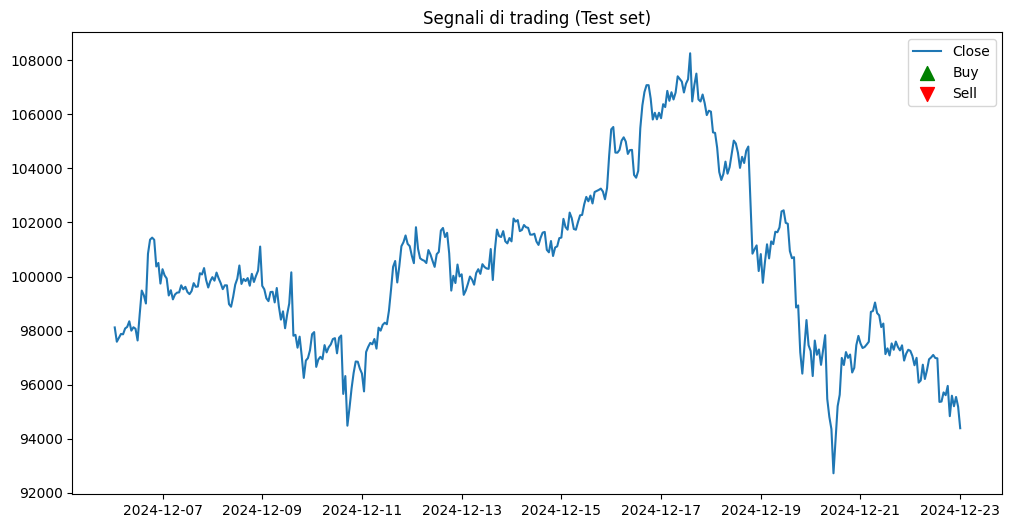

In [45]:
###############################################################################
# ESEMPIO DI UTILIZZO CON SPLIT TRAIN/VAL/TEST
###############################################################################
if __name__ == "__main__":
    # Supponiamo di avere un CSV con colonna 'Date' e 'close'
    # Carichiamo i dati
    # Esempio generico, sostituisci con il tuo dataset reale
    # df_main = pd.read_csv('btc_data.csv', parse_dates=['Date'])
    
    # Per dimostrazione, creo un df_main fittizio
    # dates = pd.date_range(start='2020-01-01', periods=500)
    # close_prices = np.linspace(7000, 30000, 500)  # trend finto
    # df_main = pd.DataFrame({'Date': dates, 'close': close_prices})
    
    # Split
    df_train, df_val, df_test = train_val_test_split(data, 
                                                     train_size=0.7, 
                                                     val_size=0.15, 
                                                     test_size=0.15, 
                                                     date_col='Date')
    
    # Parametri (puoi cambiarli a piacere)
    params = {
        'date_col': 'Date',
        'close_col': 'close',
        'initial_balance': 1000.0,
        'use_smooth': True,
        'cutoff': 0.05,
        'order': 2,
        'smooth_col': 'smoothed',
        'window': 10,
        'cycle_min': 20,
        'cycle_max': 50,
        'tolerance': 5,
        'min_price_change': 10,
        'min_gap': 15,
        'fee_percent': 0.1
    }
    
    # Applico la pipeline su TRAIN
    df_train_proc, train_balance, train_cycles = apply_pipeline(df_train.copy(), **params)
    print(f"Train final balance: {train_balance:.2f} USDT")
    
    # Applico la pipeline su VALIDATION
    df_val_proc, val_balance, val_cycles = apply_pipeline(df_val.copy(), **params)
    print(f"Validation final balance: {val_balance:.2f} USDT")
    
    # Una volta decisi i parametri ottimali su val, si può testare su test
    df_test_proc, test_balance, test_cycles = apply_pipeline(df_test.copy(), **params)
    print(f"Test final balance: {test_balance:.2f} USDT")
    
    # Se vuoi, puoi anche plottare i segnali sul dataset di test
    plt.figure(figsize=(12,6))
    plt.plot(df_test_proc['Date'], df_test_proc['close'], label='Close')
    buy_points = df_test_proc[df_test_proc['signal'] == 1]
    sell_points = df_test_proc[df_test_proc['signal'] == -1]
    plt.scatter(buy_points['Date'], buy_points['close'], marker='^', color='g', s=100, label='Buy')
    plt.scatter(sell_points['Date'], sell_points['close'], marker='v', color='r', s=100, label='Sell')
    plt.legend()
    plt.title('Segnali di trading (Test set)')
    plt.show()

## Grid search

In [46]:
import itertools

In [47]:
# param_grid = {
#     'cutoff':       [0.01, 0.05, 0.1],       # Filtro passa-basso
#     'order':        [2, 3],
#     'window':       [5, 10, 15],            # per min_local / max_local
#     'cycle_min':    [10, 20, 30],
#     'cycle_max':    [50, 80, 120],
#     'tolerance':    [5, 10],
#     'min_price_change': [5, 10, 15],
#     'min_gap':      [5, 10, 15]
# }

In [48]:
# def super_grid_search(df_train, df_val, fixed_params, param_grid):
#     """
#     Esegue una ricerca a griglia sui parametri in param_grid.
#     - df_train e df_val: DataFrame di train e validation
#     - fixed_params: dizionario con parametri fissi (ad es. commissioni, colonna date, etc.)
#     - param_grid: dizionario con liste di possibili valori
    
#     Ritorna:
#       best_params (il dizionario di parametri con la performance migliore su df_val)
#       best_val_balance (il balance migliore su validation)
#       results_list (lista di tuple con (param_combo, val_balance) per ogni combinazione)
#     """
    
#     keys = list(param_grid.keys())
#     # Creiamo tutte le combinazioni
#     param_combinations = list(itertools.product(*[param_grid[k] for k in keys]))
    
#     best_val_balance = -np.inf
#     best_params = None
#     results_list = []
    
#     for ind, combo in enumerate(param_combinations, start=1):
#         # Costruiamo un dizionario param => value
#         combo_dict = dict(zip(keys, combo))
        
#         # Uniamo i parametri fissi + parametri combo
#         all_params = {**fixed_params, **combo_dict}
        
#         # 1) Applica pipeline su TRAIN (facoltativo se devi "imparare" qualcosa su train,
#         #    ma in questo caso la pipeline è "fixed rules" => la passiamo su validation)
        
#         # 2) Applica pipeline su VALIDATION
#         _, val_balance, _ = apply_pipeline(df_val.copy(), **all_params)
        
#         # Salviamo i risultati
#         results_list.append((combo_dict, val_balance))
#         print(f'Combinazione {ind}/{len(param_combinations)}')
#         print('combo_dict:\n', combo_dict)
#         print('val_balance:\n', val_balance)
#         print('')
        
#         # Aggiorniamo best
#         if val_balance > best_val_balance:
#             best_val_balance = val_balance
#             best_params = combo_dict
#             best_ind = ind
            
#         print(f'Parametri migliori trovati finora (combinazione numero {best_ind}):', best_params)
#         print('Con portafoglio finale:', best_val_balance)
#         print('\n\n')
    
#     return best_params, best_val_balance, results_list

In [49]:
import itertools
import numpy as np

def super_grid_search(df_train, df_val, fixed_params, param_grid, start_ind):
    """
    Esegue una ricerca a griglia sui parametri in param_grid.
    - df_train e df_val: DataFrame di train e validation
    - fixed_params: dict con parametri fissi (es. fee_percent, date_col, etc.)
    - param_grid: dict con liste di possibili valori
    
    Ritorna:
      best_params (dizionario con la combinazione di parametri migliore su df_val)
      best_val_balance (il balance migliore su validation)
      results_list (lista di tuple (combo_dict, val_balance) per ogni combinazione)
    """
    
    # Estraggo le chiavi da param_grid (nomi parametri "variabili")
    keys = list(param_grid.keys())
    # Genero tutte le combinazioni possibili di parametri (cartesiano)
    param_combinations = list(itertools.product(*[param_grid[k] for k in keys]))
    
    best_val_balance = -np.inf
    best_params = None
    results_list = []
    best_ind = 0
    
    for ind, combo in enumerate(param_combinations, start=1):
        if ind >= start_ind:
            # combo è una tupla con i valori dei parametri
            combo_dict = dict(zip(keys, combo))  # es. {'cutoff':0.01, 'order':2, ...}
            
            # Unisco i parametri fissi e quelli della combo
            all_params = {**fixed_params, **combo_dict}
            
            # (Opzionale) puoi fare qualcosa su df_train qui, se necessario
            # Per ora, la strategia è "fixed rules" => non facciamo "fit" su train.
            
            # 2) Testo la pipeline su VALIDATION
            _, val_balance, _ = apply_pipeline(df_val.copy(), **all_params)
            
            # Salvo i risultati
            results_list.append((combo_dict, val_balance))
            print(f'Combinazione {ind}/{len(param_combinations)}')
            print('combo_dict:', combo_dict)
            print('val_balance:', val_balance, '\n')
            
            # Aggiorno il "best" se necessario
            if val_balance > best_val_balance:
                best_val_balance = val_balance
                best_params = combo_dict
                best_ind = ind
                
            print(f'Parametri migliori finora (combinazione {best_ind}): {best_params}')
            print('Miglior portafoglio su validation:', best_val_balance, '\n\n')
    
    return best_params, best_val_balance, results_list

In [50]:
# if __name__ == "__main__":
#     # 1) Carico i dati (ce li ho già)
    
#     # 2) Splittiamo train/val/test
#     df_train, df_val, df_test = train_val_test_split(data, 
#                                                      train_size=0.7, 
#                                                      val_size=0.15, 
#                                                      test_size=0.15, 
#                                                      date_col='Date')

#     # 3) Parametri "fissi" (tipo fee e capitale iniziale)
#     fixed_params = {
#         'date_col': 'Date',
#         'close_col': 'close',
#         'initial_balance': 1000.0,
#         'fee_percent': 0.1,   # 0.1% buy, 0.1% sell
#         'use_smooth': True,
#     }

#     # 4) Definiamo la griglia di parametri
#     param_grid = {
#         'cutoff':           [0.001, 0.01, 0.05, 0.1, 0.2],
#         'order':            [1, 2, 3, 4],
#         'window':           [3, 7, 14, 20],
#         'cycle_min':        [1, 3, 6, 12],
#         'cycle_max':        [24, 30, 48],
#         'tolerance':        [1, 3, 6, 10],
#         'min_price_change': [0.5, 2, 5, 10],
#         'min_gap':          [1, 3, 5, 10]
#     }
    
#     # 5) Facciamo la super grid search
#     best_params, best_val_balance, results_list = super_grid_search(
#         df_train=df_train,
#         df_val=df_val,
#         fixed_params=fixed_params,
#         param_grid=param_grid
#     )
    
#     print("Best params on validation set:", best_params)
#     print("Best validation balance:", best_val_balance)

#     # 6) Con i best_params su validation, proviamo su test
#     final_params = {**fixed_params, **best_params}
#     df_test_proc, test_balance, test_cycles = apply_pipeline(df_test.copy(), **final_params)
#     print("Test final balance with best_params:", test_balance)

# # Best params on validation set: {'cutoff': 0.001, 'order': 1, 'window': 7, 'cycle_min': 3, 'cycle_max': 21, 'tolerance': 10, 'min_price_change': 5, 'min_gap': 1}
# # Best validation balance: 1182.3500982743315
# # Test final balance with best_params: 1000.0

In [53]:
# 1) Carico i dati (li hai già in 'data' probabilmente)

# 2) Splittiamo train/val/test
df_train, df_val, df_test = train_val_test_split(
    data, 
    train_size=0.7, 
    val_size=0.15, 
    test_size=0.15, 
    date_col='Date'
)

# 3) Parametri "fissi" (ora fee_percent è decimale, es. 0.001 => 0.1%)
fixed_params = {
    'date_col': 'Date',
    'close_col': 'close',
    'initial_balance': 1000.0,
    'initial_bitcoin': 0.0,
    'fee_percent': 0.001,  # 0.1% a trade
    'use_smooth': True
}

# 4) Definiamo la griglia di parametri
# (Puoi aggiungere qui: first_buy_pct, buy_coefficient, do_buy, etc.
#  se vuoi ottimizzarli anch'essi.)
param_grid = {
    'cutoff':           [0.0001, 0.001],
    'order':            [1],
    'window':           [5, 7],
    'cycle_min':        [1, 3, 6],
    'cycle_max':        [12, 24],
    'tolerance':        [1, 3],
    'min_price_change': [2, 5],
    'min_gap':          [1, 3],
    'first_buy_pct':    [0.2, 0.5, 1],
    'use_weighted_avg': [True, False],
    'buy_coefficient':  [0.5, 1, 3],
    'do_buy':           [True, False]
}

start_ind = 1

# 5) Eseguiamo la super grid search
best_params, best_val_balance, results_list = super_grid_search(
    df_train=df_train,
    df_val=df_val,
    fixed_params=fixed_params,
    param_grid=param_grid,
    start_ind=start_ind
)

print("Best params on validation set:", best_params)
print("Best validation balance:", best_val_balance)

# 6) Con i best_params, testiamo su df_test
final_params = {**fixed_params, **best_params}
df_test_proc, test_balance, test_cycles = apply_pipeline(df_test.copy(), **final_params)
print("Test final balance with best_params:", test_balance)

# 7) (Opzionale) stampare tutte le combinazioni testate
# for combo_dict, val_bal in results_list:
#     print(combo_dict, val_bal)

# Parametri migliori finora (combinazione 4021): {'cutoff': 0.001, 'order': 1, 'window': 7, 'cycle_min': 1, 'cycle_max': 24, 'tolerance': 1, 'min_price_change': 2, 'min_gap': 1, 'first_buy_pct': 0.2, 'use_weighted_avg': True, 'buy_coefficient': 1, 'do_buy': True}
# Miglior portafoglio su validation: 1030.2498962611342 

Combinazione 1/6912
combo_dict: {'cutoff': 0.0001, 'order': 1, 'window': 5, 'cycle_min': 1, 'cycle_max': 12, 'tolerance': 1, 'min_price_change': 2, 'min_gap': 1, 'first_buy_pct': 0.2, 'use_weighted_avg': True, 'buy_coefficient': 0.5, 'do_buy': True}
val_balance: 1018.471321914672 

Parametri migliori finora (combinazione 1): {'cutoff': 0.0001, 'order': 1, 'window': 5, 'cycle_min': 1, 'cycle_max': 12, 'tolerance': 1, 'min_price_change': 2, 'min_gap': 1, 'first_buy_pct': 0.2, 'use_weighted_avg': True, 'buy_coefficient': 0.5, 'do_buy': True}
Miglior portafoglio su validation: 1018.471321914672 


Combinazione 2/6912
combo_dict: {'cutoff': 0.0001, 'order': 1, 'window': 5, 'cycle_min': 1, 'cycle_max': 12, 'tolerance': 1, 'min_price_change': 2, 'min_gap': 1, 'first_buy_pct': 0.2, 'use_weighted_avg': True, 'buy_coefficient': 0.5, 'do_buy': False}
val_balance: 1018.471321914672 

Parametri migliori finora (combinazione 1): {'cutoff': 0.0001, 'order': 1, 'window': 5, 'cycle_min': 1, 'cycle_max'

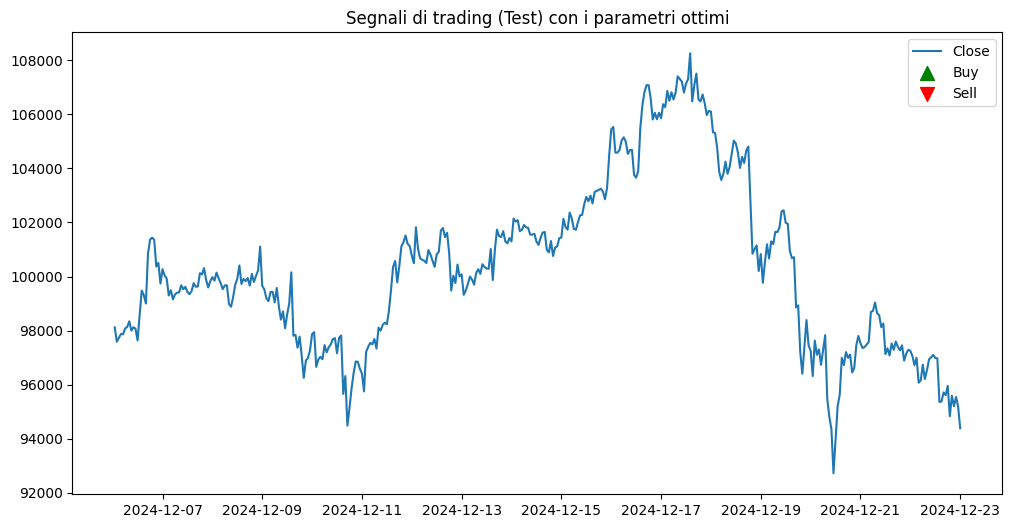

In [58]:
# 7) Se vuoi, puoi stampare tutte le combinazioni testate e i relativi bilanci
    # for combo_dict, val_bal in results_list:
    #     print(combo_dict, val_bal)

# 8) Plot finale (opzionale)
plt.figure(figsize=(12,6))
plt.plot(df_test_proc['Date'], df_test_proc['close'], label='Close')
buy_points = df_test_proc[df_test_proc['signal'] == 1]
sell_points = df_test_proc[df_test_proc['signal'] == -1]
plt.scatter(buy_points['Date'], buy_points['close'], 
            marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_points['Date'], sell_points['close'], 
            marker='v', color='r', s=100, label='Sell')
plt.legend()
plt.title('Segnali di trading (Test) con i parametri ottimi')
plt.show()